### Implementation of LoRA with BERT on Emotion Detection

In [ ]:
!pip install transformers datasets peft accelerate evaluate

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer, pipeline
from datasets import load_dataset
from peft import LoraConfig, get_peft_model
import evaluate
import torch

dataset = load_dataset("dair-ai/emotion")
dataset["train"] = dataset["train"].shuffle(seed=42).select(range(3000))
dataset["validation"] = dataset["validation"].shuffle(seed=42).select(range(500))
dataset["test"] = dataset["test"].shuffle(seed=42).select(range(500))



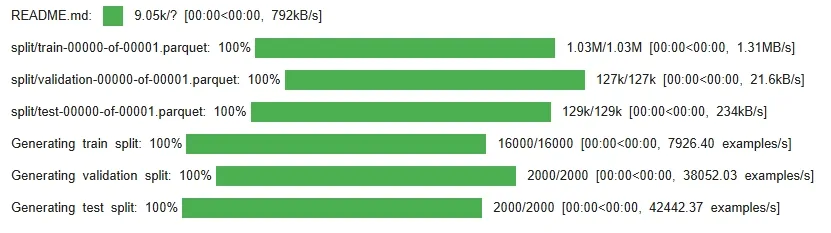

In [ ]:
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def preprocess(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=128)

dataset = dataset.map(preprocess, batched=True).rename_column("label", "labels")
dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=6)

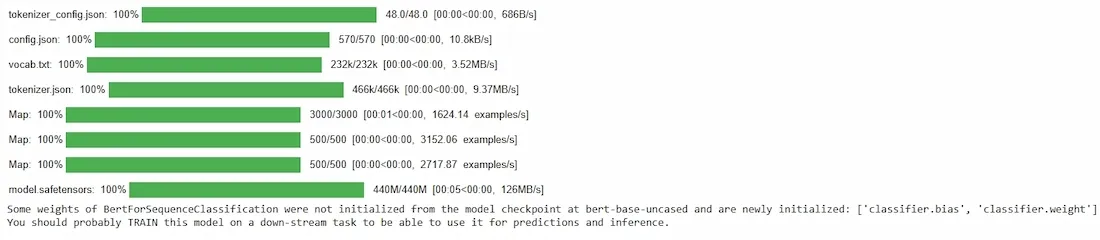

In [ ]:
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["query", "value"],  
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_CLS"
)
model = get_peft_model(model, lora_config)


metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    return metric.compute(predictions=preds, references=labels)

args = TrainingArguments(
    output_dir="./lora_emotion",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=2e-4,
    num_train_epochs=2,    
    eval_strategy="epoch",
    logging_steps=10,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    compute_metrics=compute_metrics
)
trainer.train()
model.save_pretrained("./lora_emotion_adapter")
print("LoRA fine-tuning complete! Adapter saved at ./lora_emotion_adapter")



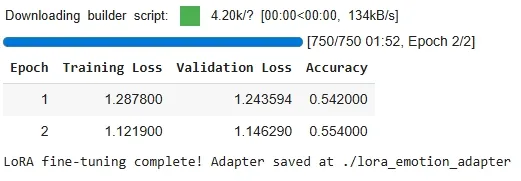

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

emotion_labels = dataset["train"].features["labels"].names

samples = [
    "I am so happy to see you!",
    "This is terrifying, I can't handle it.",
    "He surprised everyone with his gift.",
    "I feel so sad and lonely.",
    "I love spending time with my family."
]

inputs = tokenizer(samples, truncation=True, padding=True, return_tensors="pt").to(device)

model.eval()
with torch.no_grad():
    logits = model(**inputs).logits
    preds = torch.argmax(logits, dim=-1)

for text, pred in zip(samples, preds):
    print(f"Text: {text}\nPredicted Emotion: {emotion_labels[pred]}\n")

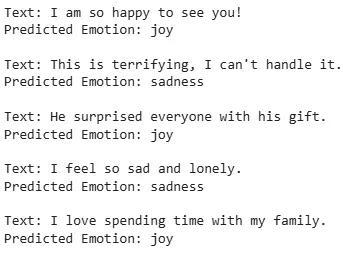